# Анализ продаж кофе

Есть файл оптового продавца с данными о продажах кофе в зёрнах 5 различных видов (производства) за 2 года среди 100 ведущих клиентов. В данных подробная информация о количестве, ценах, скидках и общем объёме продаж.

Поля данных
- `Date`: дата покупки
- `Customer_ID`: уникальный идентификатор покупателя
- `Category`: категория товара (кофе в зёрнах)
- `Product`: тип кофе (Бразильский, Эфиопский, Колумбийский, Коста-Рика, Гватемала)
- `Unit Price`: цена за единицу каждого товара
- `Quantity`: количество купленного товара
- `Sales Amount`: сумма продажи (количество × цена единицы)
- `Used_Discount`: была ли применена скидка (True/False)
- `Discount_Amount`: применённая величина скидки (20%)
- `Final Sales`: общая сумма продажи после скидки

## Загрузка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import chardet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import scipy.stats as stats

print('Импорт библиотек и конфигурирование среды завершены.')

with open('coffee_sales2.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(f"Кодировка файла: {result['encoding']} (уверенность: {result['confidence']:.2f})")

Импорт библиотек и конфигурирование среды завершены.
Кодировка файла: utf-8 (уверенность: 0.99)


In [2]:
# Загрузка данных
file = 'coffee_sales2.csv'
df = pd.read_csv(file, encoding='utf-8', delimiter=',')
print('В датафрейме строк и столбцов:', df.shape)

В датафрейме строк и столбцов: (730, 11)


In [3]:
# Функция получения полной информации о датафрейме
def data_info(data):
    # Функция для вывода заголовка с жирным шрифтом
    def print_header(title):
        print(f'\033[1m{title}\033[0m')

    # Первые 10 строк
    print_header('Первые 10 строк:')
    display(data.head(10))
    print('-------------')

    # Последние 10 строк
    print_header('Последние 10 строк:')
    display(data.tail(10))
    print('-------------')

    # Типы данных
    print_header('Типы данных:')
    display(data.info(memory_usage='deep'))
    print('-------------')

    # Полное статистическое описание
    print_header('Полное статистическое описание:')
    display(data.describe(include='all'))
    print('-------------')

    # Категориальные признаки
    print_header('Категориальные признаки:')
    display(data.describe(include=[object]))
    print('-------------')

    # Пропуски
    print_header('Пропуски:')
    missing_data = data.isna().sum()
    for col in data.columns:
        if missing_data[col] > 0:
            print(f"Столбец {col} имеет {missing_data[col]} пропусков")
        else:
            print(f"В столбце {col} пропусков НЕТ")
    print('-------------')

    # Доля пропусков
    print_header('Доля пропусков от всех данных:')
    display((data.isna().mean() * 100).sort_values(ascending=False))
    print('-------------')

    # Явные дубликаты
    print_header('Явные дубликаты:')
    duplicated_count = data.duplicated().sum()
    print(f"Дубликатов: {duplicated_count}" if duplicated_count > 0 else "Явных дублей НЕТ")
    print('-------------')

data_info(df)

Первые 10 строк:


,Date,Customer_ID,City,Category,Product,Unit Price,Quantity,Sales Amount,Used_Discount,Discount_Amount,Final Sales
0,1/1/2023,32,Москва,зерновой,Колумбийский,40,14,560,False,0,560
1,1/2/2023,49,Санкт-Петербург,зерновой,Коста-Рика,35,17,595,False,0,595
2,1/3/2023,75,Новосибирск,зерновой,Коста-Рика,35,19,665,False,0,665
3,1/4/2023,80,Санкт-Петербург,зерновой,Эфиопский,45,1,45,False,0,45
4,1/5/2023,78,Екатеринбург,зерновой,Колумбийский,40,46,1840,True,368,1472
5,1/6/2023,1,Казань,зерновой,Колумбийский,40,32,1280,True,256,1024
6,1/7/2023,95,Нижний Новгород,зерновой,Бразильский,30,1,30,True,6,24
7,1/8/2023,27,Челябинск,зерновой,Колумбийский,40,33,1320,False,0,1320
8,1/9/2023,73,Екатеринбург,зерновой,Гватемала,35,47,1645,False,0,1645
9,1/10/2023,82,Самара,зерновой,Коста-Рика,35,4,140,False,0,140


-------------
Последние 10 строк:


,Date,Customer_ID,City,Category,Product,Unit Price,Quantity,Sales Amount,Used_Discount,Discount_Amount,Final Sales
720,12/21/2024,22,Омск,зерновой,Коста-Рика,35,15,525,True,105,420
721,12/22/2024,72,Казань,зерновой,Колумбийский,40,43,1720,True,344,1376
722,12/23/2024,83,Омск,зерновой,Бразильский,30,4,120,False,0,120
723,12/24/2024,49,Санкт-Петербург,зерновой,Бразильский,30,28,840,False,0,840
724,12/25/2024,20,Екатеринбург,зерновой,Коста-Рика,35,46,1610,False,0,1610
725,12/26/2024,4,Екатеринбург,зерновой,Колумбийский,40,26,1040,False,0,1040
726,12/27/2024,63,Ростов-на-Дону,зерновой,Колумбийский,40,10,400,False,0,400
727,12/28/2024,39,Санкт-Петербург,зерновой,Коста-Рика,35,47,1645,False,0,1645
728,12/29/2024,57,Новосибирск,зерновой,Эфиопский,45,3,135,True,27,108
729,12/30/2024,50,Челябинск,зерновой,Бразильский,30,33,990,True,198,792


-------------
Типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             730 non-null    object
 1   Customer_ID      730 non-null    int64 
 2   City             730 non-null    object
 3   Category         730 non-null    object
 4   Product          730 non-null    object
 5   Unit Price       730 non-null    int64 
 6   Quantity         730 non-null    int64 
 7   Sales Amount     730 non-null    int64 
 8   Used_Discount    730 non-null    bool  
 9   Discount_Amount  730 non-null    int64 
 10  Final Sales      730 non-null    int64 
dtypes: bool(1), int64(6), object(4)
memory usage: 257.4 KB


None

-------------
Полное статистическое описание:


,Date,Customer_ID,City,Category,Product,Unit Price,Quantity,Sales Amount,Used_Discount,Discount_Amount,Final Sales
count,730,730.000000,730,730,730,730.000000,730.000000,730.000000,730,730.000000,730.000000
unique,730,NaN,10,1,5,NaN,NaN,NaN,2,NaN,NaN
top,1/1/2023,NaN,Екатеринбург,зерновой,Коста-Рика,NaN,NaN,NaN,True,NaN,NaN
freq,1,NaN,87,730,165,NaN,NaN,NaN,371,NaN,NaN
mean,NaN,51.669863,NaN,NaN,NaN,36.794521,26.080822,959.924658,NaN,97.393151,862.531507
std,NaN,29.014339,NaN,NaN,NaN,4.955104,14.480971,551.282730,NaN,123.401350,509.032315
min,NaN,1.000000,NaN,NaN,NaN,30.000000,1.000000,30.000000,NaN,0.000000,24.000000
25%,NaN,27.250000,NaN,NaN,NaN,35.000000,14.000000,495.000000,NaN,0.000000,448.000000
50%,NaN,52.000000,NaN,NaN,NaN,35.000000,27.000000,960.000000,NaN,13.000000,840.000000
75%,NaN,77.000000,NaN,NaN,NaN,40.000000,39.000000,1400.000000,NaN,192.000000,1260.000000


-------------
Категориальные признаки:


,Date,City,Category,Product
count,730,730,730,730
unique,730,10,1,5
top,1/1/2023,Екатеринбург,зерновой,Коста-Рика
freq,1,87,730,165


-------------
Пропуски:
В столбце Date пропусков НЕТ
В столбце Customer_ID пропусков НЕТ
В столбце City пропусков НЕТ
В столбце Category пропусков НЕТ
В столбце Product пропусков НЕТ
В столбце Unit Price пропусков НЕТ
В столбце Quantity пропусков НЕТ
В столбце Sales Amount пропусков НЕТ
В столбце Used_Discount пропусков НЕТ
В столбце Discount_Amount пропусков НЕТ
В столбце Final Sales пропусков НЕТ
-------------
Доля пропусков от всех данных:


Date               0.0
Customer_ID        0.0
City               0.0
Category           0.0
Product            0.0
Unit Price         0.0
Quantity           0.0
Sales Amount       0.0
Used_Discount      0.0
Discount_Amount    0.0
Final Sales        0.0
dtype: float64

-------------
Явные дубликаты:
Явных дублей НЕТ
-------------


В данных нет пропусков и явных дублей, но с датафреймом нужно поработать.
- Столбец `Date` имеет тип *object* (строка). Для оптимизации преобразуем его в тип *datetime*.
- Столбец `Customer_ID` имеет текущий тип *int64*, хотя у нас всего 730 записей  (количество явно меньше 65 535), поэтому можно использовать *uint16*.
- Столбцы `Unit Price`, `Quantity`, `Sales Amount`, `Discount_Amount`, `Final Sales` из текущего типа *int64* также преобразуем в *int16*.
- Столбец `Used_Discount` имеет тип *bool*, который уже оптимален, но для экономии памяти, а также для будущих расчётов можно использовать тип *uint8* (0 или 1).
- Столбцы `City`, `Category`, `Product` с названиями имеют тип *object* (строка), хотя можно преобразовать в тип *category*, если количество уникальных значений значительно меньше общего количества строк (730).

Кроме того, названия столбцов сделаем более удобными для работы, убрав пробелы и приведя в нижний регистр.

## Предобработка данных

In [4]:
# Оптимизация типов данных
df['Date'] = pd.to_datetime(df['Date'])
df['Customer_ID'] = df['Customer_ID'].astype('uint16')
df['Unit Price'] = df['Unit Price'].astype('int16')
df['Quantity'] = df['Quantity'].astype('int16')
df['Sales Amount'] = df['Sales Amount'].astype('int16')
df['Discount_Amount'] = df['Discount_Amount'].astype('int16')
df['Final Sales'] = df['Final Sales'].astype('int16')
#df['Used_Discount'] = df['Used_Discount'].astype('uint8')
df['City'] = df['City'].astype('category')
df['Category'] = df['Category'].astype('category')
df['Product'] = df['Product'].astype('category')

# Проверка изменений
print(f'Новые типы данных:\n{df.dtypes}')
print()
print(f'Занятая память в байтах:\n{df.memory_usage(deep=True)}')

Новые типы данных:
Date               datetime64[ns]
Customer_ID                uint16
City                     category
Category                 category
Product                  category
Unit Price                  int16
Quantity                    int16
Sales Amount                int16
Used_Discount                bool
Discount_Amount             int16
Final Sales                 int16
dtype: object

Занятая память в байтах:
Index               132
Date               5840
Customer_ID        1460
City               2088
Category            937
Product            1440
Unit Price         1460
Quantity           1460
Sales Amount       1460
Used_Discount       730
Discount_Amount    1460
Final Sales        1460
dtype: int64


In [5]:
def rename_columns(data):
    """
    Функция переименования столбцов:
    - Переводит к нижнему регистру.
    - Убирает пробелы в начале и в конце.
    - Убирает скобки.
    - Заменяет пробелы внутри названий на символ подчёркивания.
    
    :param df: Исходный датафрейм.
    :return: датафрейм с переименованными столбцами.
    """
    # Функция для обработки одного названия столбца
    def clean_column_name(col_name):
        # Переводим к нижнему регистру
        col_name = col_name.lower()
        # Убираем пробелы в начале и в конце
        col_name = col_name.strip()
        # Убираем скобки
        col_name = col_name.replace('(', '').replace(')', '')
        # Заменяем пробелы на подчёркивания
        col_name = col_name.replace(' ', '_')
        return col_name
    
    # Применяем функцию ко всем названиям столбцов
    data.columns = [clean_column_name(col) for col in data.columns]
    return data

# Используем
df = rename_columns(df)
print("\nНовые названия столбцов:")
df.columns.tolist()


Новые названия столбцов:


['date',
 'customer_id',
 'city',
 'category',
 'product',
 'unit_price',
 'quantity',
 'sales_amount',
 'used_discount',
 'discount_amount',
 'final_sales']

In [6]:
display(df.head(10))

,date,customer_id,city,category,product,unit_price,quantity,sales_amount,used_discount,discount_amount,final_sales
0,2023-01-01,32,Москва,зерновой,Колумбийский,40,14,560,False,0,560
1,2023-01-02,49,Санкт-Петербург,зерновой,Коста-Рика,35,17,595,False,0,595
2,2023-01-03,75,Новосибирск,зерновой,Коста-Рика,35,19,665,False,0,665
3,2023-01-04,80,Санкт-Петербург,зерновой,Эфиопский,45,1,45,False,0,45
4,2023-01-05,78,Екатеринбург,зерновой,Колумбийский,40,46,1840,True,368,1472
5,2023-01-06,1,Казань,зерновой,Колумбийский,40,32,1280,True,256,1024
6,2023-01-07,95,Нижний Новгород,зерновой,Бразильский,30,1,30,True,6,24
7,2023-01-08,27,Челябинск,зерновой,Колумбийский,40,33,1320,False,0,1320
8,2023-01-09,73,Екатеринбург,зерновой,Гватемала,35,47,1645,False,0,1645
9,2023-01-10,82,Самара,зерновой,Коста-Рика,35,4,140,False,0,140


## Исследовательский анализ данных

In [7]:
# Сводная статистика для числовых столбцов
print('Сводная статистика для числовых столбцов:')
print(df.describe())

Сводная статистика для числовых столбцов:
                      date  customer_id  unit_price    quantity  sales_amount  \
count                  730   730.000000  730.000000  730.000000    730.000000   
mean   2023-12-31 12:00:00    51.669863   36.794521   26.080822    959.924658   
min    2023-01-01 00:00:00     1.000000   30.000000    1.000000     30.000000   
25%    2023-07-02 06:00:00    27.250000   35.000000   14.000000    495.000000   
50%    2023-12-31 12:00:00    52.000000   35.000000   27.000000    960.000000   
75%    2024-06-30 18:00:00    77.000000   40.000000   39.000000   1400.000000   
max    2024-12-30 00:00:00   100.000000   45.000000   49.000000   2205.000000   
std                    NaN    29.014339    4.955104   14.480971    551.282730   

       discount_amount  final_sales  
count       730.000000   730.000000  
mean         97.393151   862.531507  
min           0.000000    24.000000  
25%           0.000000   448.000000  
50%          13.000000   840.000000  


Разберём каждый столбец и его статистику.

1. Столбец **`date`** - дата продажи
     - count (количество записей): **всего 730 строк** (*в дальнейшем описании уберём, если не будет расхождений*).
     - mean (среднее значение): —  средняя дата в данных 31 декабря 2023 года 12:00:00.
     - min (минимальное значение): минимальная дата в данных 1 января 2023 года.
     - 25% (25-й процентиль): в датах это 2 июля 2023 года 06:00:00.
     - 50% (медиана): у дат это 31 декабря 2023 года 12:00:00.
     - 75% (75-й процентиль): здесь это 30 июня 2024 года 18:00:00.
     - max (максимальное значение): максимум у дат 30 декабря 2024 года.
     - std (стандартное отклонение): `NaN` —  для дат не вычисляется, так как это не числовой тип.

2. Столбец **`customer_id`** - ID покупателя
     - mean: **51.67** - видимо, есть повторы, потому что должно быть 50.
     - min: **1**, как и должно быть.
     - 25%: **27.25** (25% значений меньше или равно 27.25).
     - 50%: **52** (50% значений меньше или равно 52).
     - 75%: **77** (75% значений меньше или равно 77).
     - max: **100** - количество клиентов равно утверждённому.
     - std: **29.01** — значения **умеренно** отклоняются от среднего.

3. Столбец **`unit_price`** - цена за единицу товара
     - mean: **36.79** — средняя цена за единицу товара.
     - min: **30** — минимальная цена за единицу товара.
     - 25%: **35** — четверть значений меньше или равно 35.
     - 50%: **35** — половина значений меньше или равно 35.
     - 75%: **40** — три четверти значений меньше или равно 40.
     - max: **45** — максимальная цена за единицу товара.
     - std: **4.96** — это стандартное отклонение показывает, что все значения **близки** к среднему, то есть разброс цен довольно небольшой.

4. Столбец **`quantity`** - количество купленного товара
     - mean: **26.08** — среднее количество товаров в заказе.
     - min: **1** — минимальное количество товаров.
     - 25%: **14** — четверть значений меньше или равно 14.
     - 50%: **27** — половина значений меньше или равно 27.
     - 75%: **39** — три четверти значений меньше или равно 39.
     - max: **49** — максимальное количество товаров.
     - std: **14.48** — стандартное отклонение показывает, что **умеренное** количество товаров отклоняется от среднего значения.

5. Столбец **`sales_amount`** - сумма продажи
     - mean: **959.92** — средняя сумма продаж.
     - min: **30** — минимальная сумма.
     - 25%: **495** — то есть 25% значений меньше или равно 495.
     - 50%: **960** — половина значений меньше или равно 960.
     - 75%: **1400** — три четверти продаж меньше или равно 1400.
     - max: **2205** — максимальная сумма продаж.
     - std: **551.28** — такое стандартное отклонение показывает, что суммы продаж **сильно** отклоняются от среднего значения.

6. Столбец **`discount_amount`** - применённая скидка
     - mean: **97.39** — средняя сумма скидки.
     - min: **0** — минимальная сумма скидки.
     - 25%: **0** — четверть значений меньше или равно 0.
     - 50%: **13** — половина значений меньше или равно 13.
     - 75%: **192** — три четверти меньше или равно 192.
     - max: **441** — максимальная сумма скидки.
     - std: **123.40** — стандартное отклонение, которое показывает **большой разброс** размеров скидок от среднего.

7. Столбец **`final_sales`** - общая сумма продажи после скидки
     - mean: **862.53** — средняя итоговая сумма продаж.
     - min: **24** — минимальная сумма.
     - 25%: **448** — четверть продаж меньше или равно 448.
     - 50%: **840** — половина продаж меньше или равно 840.
     - 75%: **1260** — три четверти значений меньше или равно 1260.
     - max: **2205** — максимальная итоговая сумма продажи.
     - std: **509.03** — это стандартное отклонение показывает, что окончательные суммы продаж **сильно** отклоняются от среднего значения.

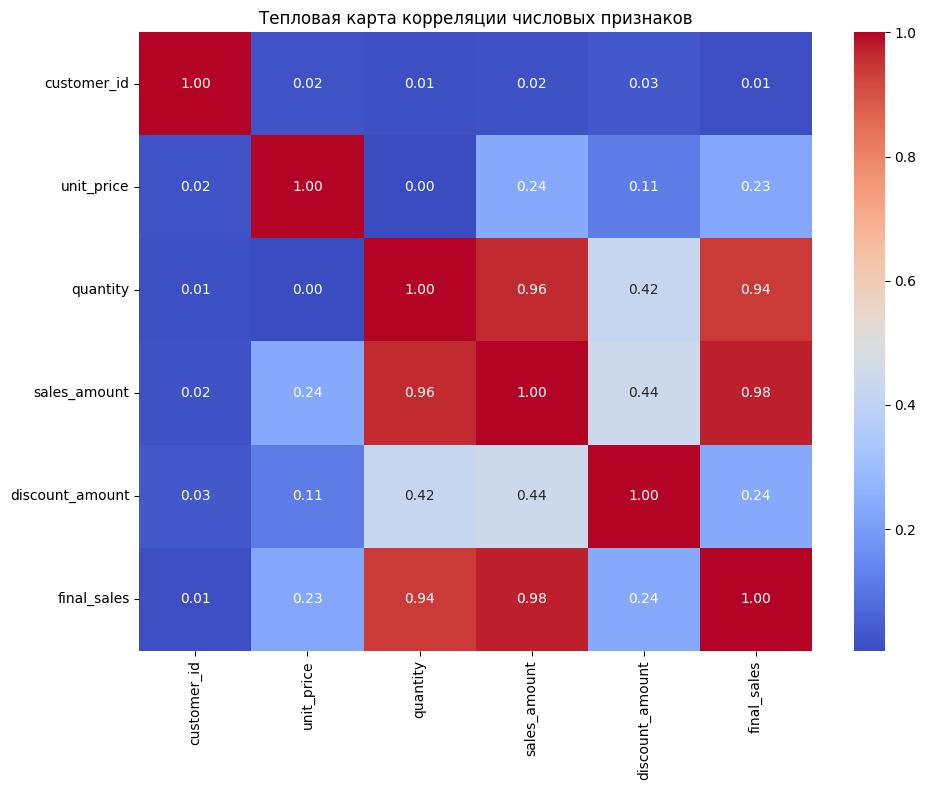

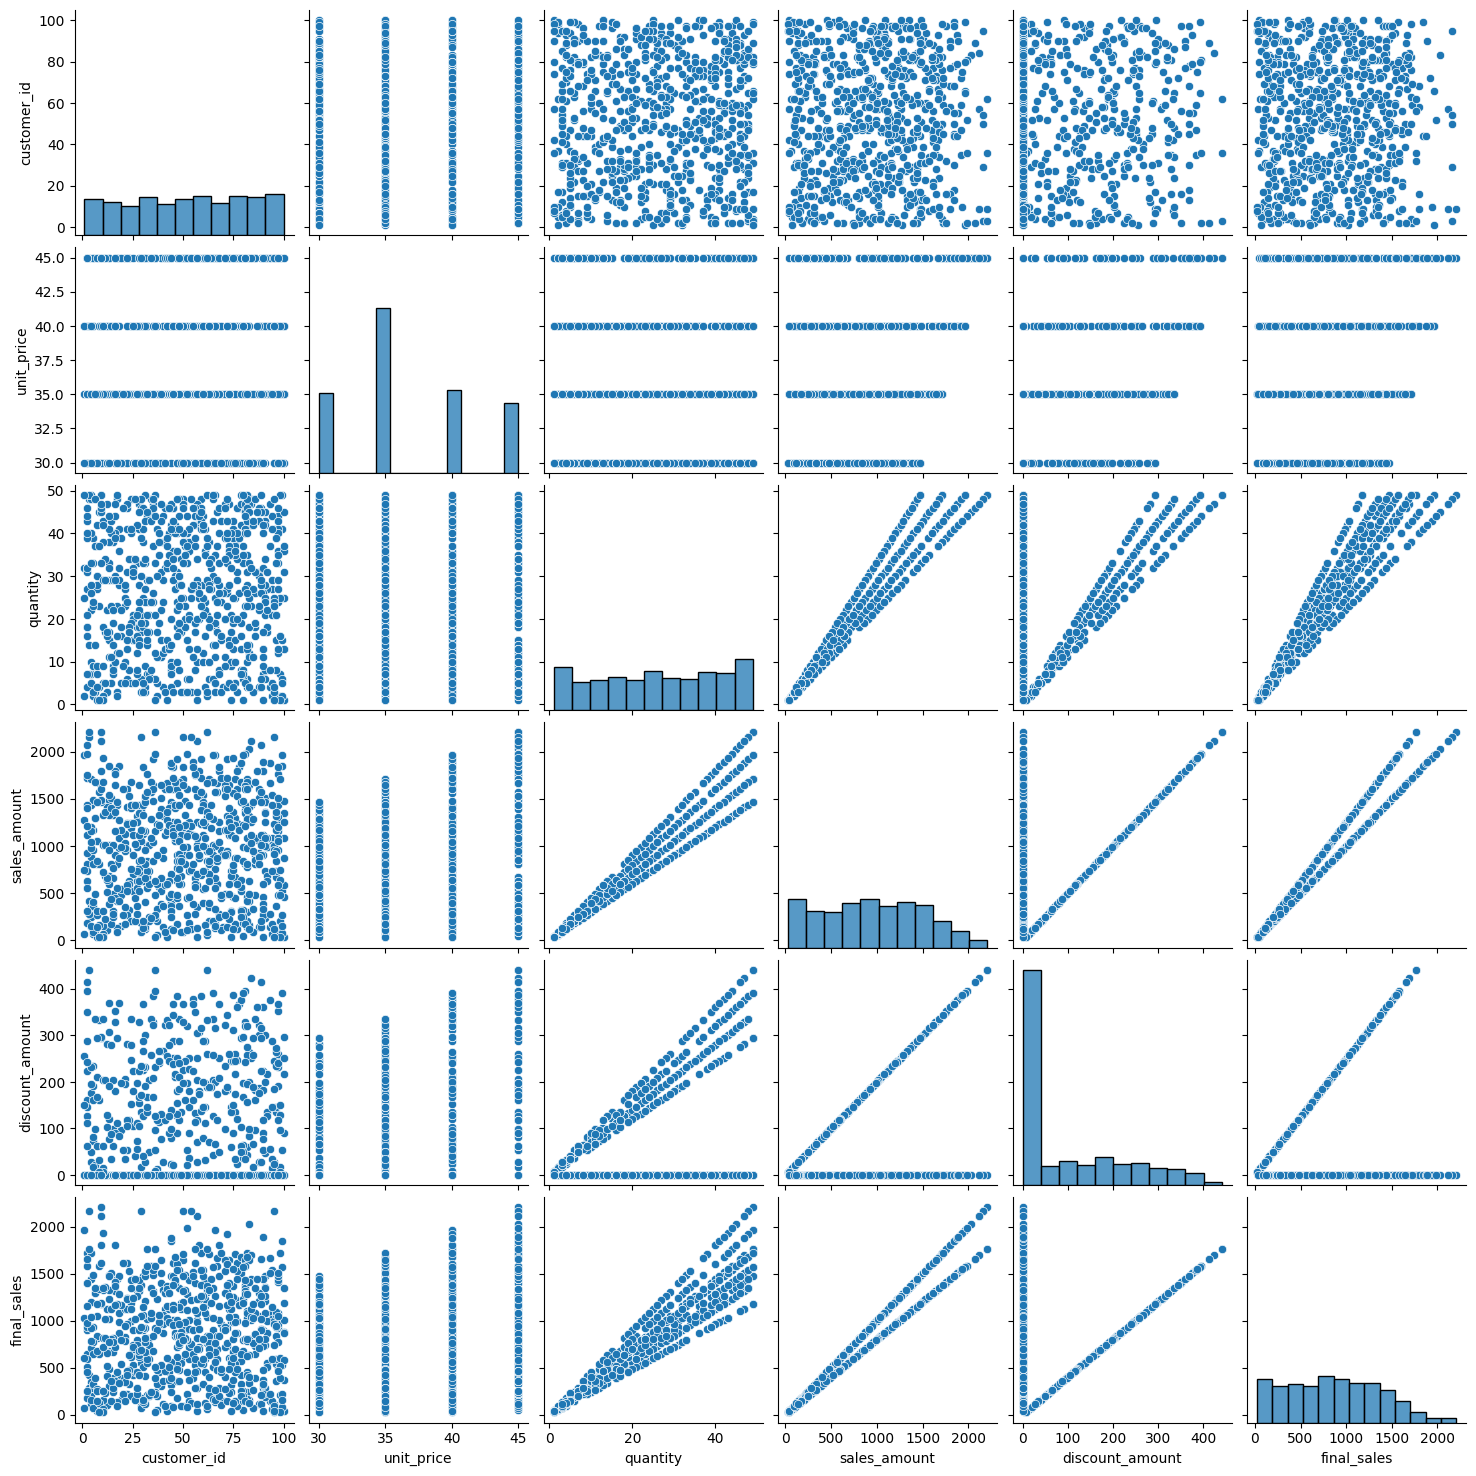

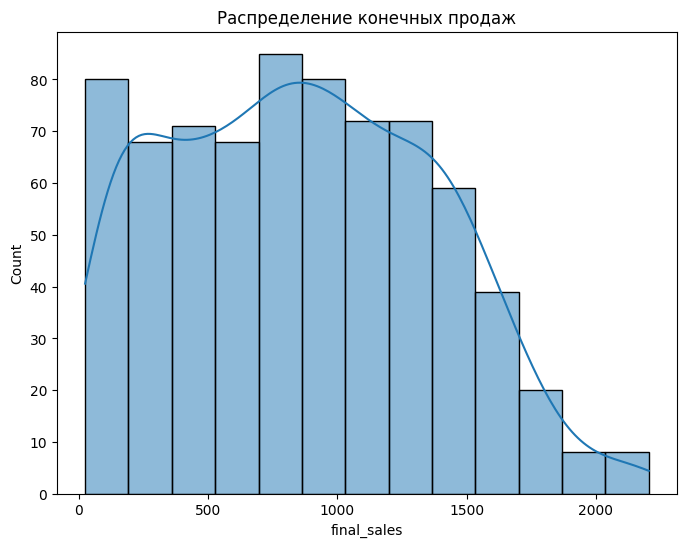

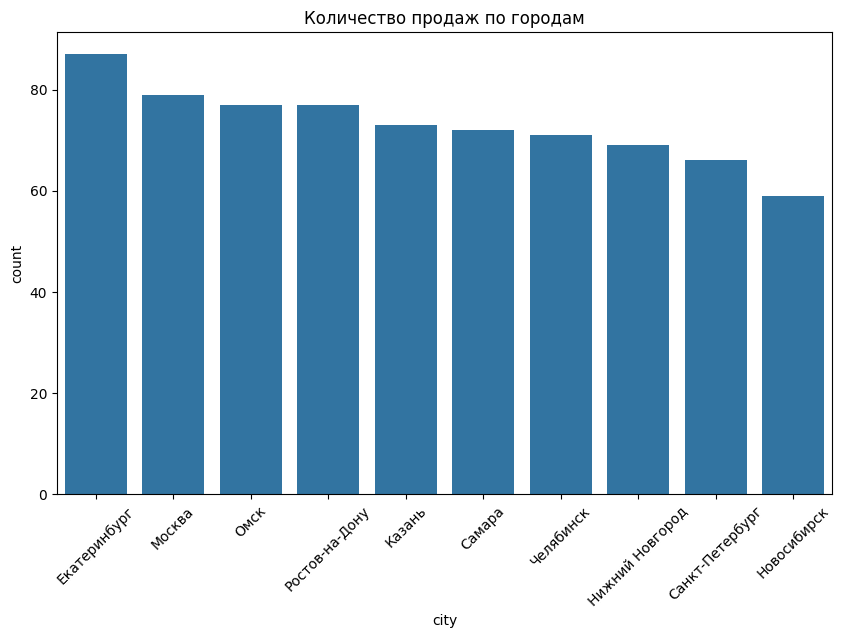

In [8]:
# Выбор числовых столбцов для корреляционного анализа
numeric_df = df.select_dtypes(include=[np.number])

# Тепловая карта корреляции (если есть хотя бы 2 числовых столбца)
if numeric_df.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Тепловая карта корреляции числовых признаков')
    plt.tight_layout()
    plt.show()  # Используем show() вместо clf()
else:
    print('Недостаточно числовых столбцов для корреляционной тепловой карты.')

# Парный график для выбранных числовых столбцов (если есть хотя бы 2 столбца)
if numeric_df.shape[1] >= 2:
    sns.pairplot(numeric_df)
    plt.show()  # Используем show() вместо clf()
else:
    print('Недостаточно числовых столбцов для парного графика.')

# Гистограмма для окончательных продаж
plt.figure(figsize=(8, 6))
sns.histplot(df['final_sales'], kde=True)
plt.title('Распределение конечных продаж')
plt.show()  # Используем show() вместо clf()

# График количества продаж по городам
plt.figure(figsize=(10, 6))
sns.countplot(x='city', data=df, order=df['city'].value_counts().index)
plt.title('Количество продаж по городам')
plt.xticks(rotation=45)
plt.show()  # Используем show() вместо clf()

Тепловая карта отображает корреляцию между различными числовыми характеристиками в наборе данных. Интенсивность цвета отражает силу корреляции: красный цвет указывает на сильную положительную корреляцию, синий - на сильную отрицательную, а белый - на отсутствие корреляции. На этой тепловой карте:
- Сильная положительная корреляция:
     - Количество и сумма продажи имеют сильную положительную корреляцию (0,96). Это вполне логично, поскольку общая сумма продаж прямо пропорциональна количеству купленных товаров.
     - сумма продажи и окончательная сумма также имеют высокую положительную корреляцию (0,98). Это ожидаемо, поскольку на конечную сумму продаж, также влияет начальная сумма продажи.
     - Количество и конечные продажи также имеют высокую положительную корреляцию (0,94), что согласуется с предыдущими наблюдениями, поскольку количество приобретённых товаров напрямую влияет на конечную сумму продаж.
- Умеренная положительная корреляция:
     - Цена за единицу и сумма продажи имеют умеренную положительную корреляцию (0,24). Это говорит о том, что при увеличении цены единицы товара сумма продаж также имеет тенденцию к увеличению.
     - Сумма скидки и применение скидки (да или нет) имеют умеренную положительную корреляцию (0,78). То есть более высокая сумма скидки часто ассоциируется с более высокой использованной скидкой.
- Слабая корреляция:
     - Большинство других пар признаков имеют слабую корреляцию, что говорит о том, что они не сильно связаны между собой. Например, customer_id имеет очень слабую корреляцию со всеми остальными характеристиками.

    В целом, тепловая карта показывает сильную связь между количеством, sales_amount и final_sales, что говорит о том, что эти характеристики оказывают большое влияние на определение конечной суммы продаж. Умеренная корреляция между unit_price и sales_amount предполагает, что цена также играет определенную роль, в то время как слабые корреляции между другими характеристиками указывают на то, что они оказывают меньшее влияние на конечную сумму продаж.